Dataset Overview:
The dataset comprises several features that are crucial for understanding the nuances of essay writing and for building a model that can accurately score these essays. Here's a brief overview of the key components of the dataset:

Essay ID: A unique identifier for each essay. This is important for tracking and analyzing individual essays.

Essay Set: Indicates the set to which an essay belongs. The dataset contains essays from different sets, each potentially having different scoring criteria or topics.

Essay: The actual text of the essay. This is the most critical part of the dataset, as the NLP model will primarily analyze this text to score the essay.

Domain Prediction ID: A feature related to the first domain of prediction for the essay score.

Domain Score: This relates to the score of essay.

In [6]:
import os
import pandas as pd
import nltk
import matplotlib.pyplot as plt
# nltk.download('stopwords')
# nltk.download('punkt')

In [3]:
DATASET_DIR = './data'
SAVE_DIR = './'

In [4]:
# Load the dataset
data_set = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')

# Extract the column that contains the essay scores
score_col = data_set['domain1_score']

# Drop columns with missing values
data_set = data_set.dropna(axis=1)

# Drop specific columns that are not needed for the analysis
data_set = data_set.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [5]:
data_set.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [9]:
data_set.shape

(12976, 4)

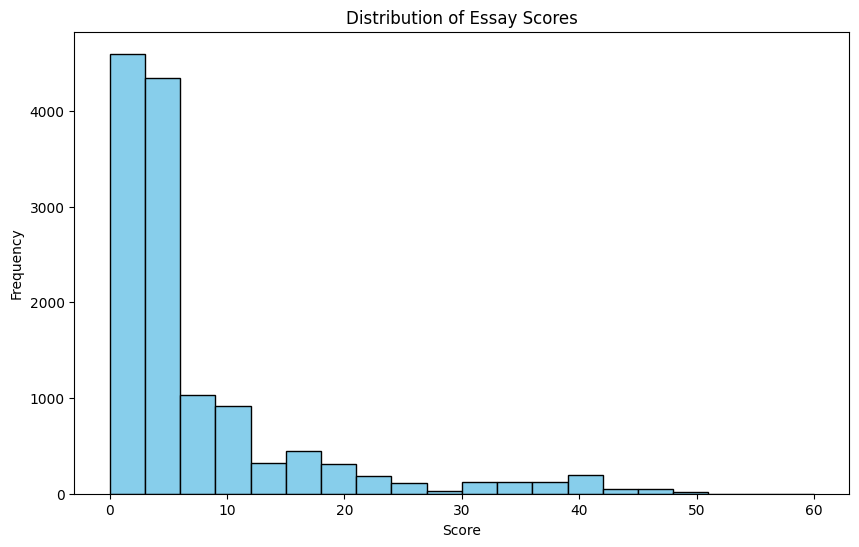

In [7]:


# Plotting the distribution of essay scores
plt.figure(figsize=(10,6))
plt.hist(score_col, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [11]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

#  If your model predicts scores, it's important to normalize these predictions within the actual scoring range of the essays. For example, 
# if an essay set has scores ranging from 2 to 12, a predicted score of 13 would be invalid.
# Before training your model, you can use these ranges to validate the data. Any essay with a score outside these ranges can be considered an anomaly or an error. 

In [15]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# Optional: Load or define a custom stopwords list
custom_stopwords = set([
    "the", "of", "and", "a", "to", "in", "is", "you", "that", "it", 
    "he", "was", "for", "on", "are", "as", "with", "his", "they", "at",
    "be", "this", "have", "from", "or", "one", "had", "by", "word", "but",
    "not", "what", "all", "were", "we", "when", "your", "can", "said", 
    "there", "use", "an", "each", "which", "she", "do", "how", "their", 
    "if", "will", "up", "other", "about", "out", "many", "then", "them",
    "these", "so", "some", "her", "would", "make", "like", "him", "into", 
    "time", "has", "look", "two", "more", "write", "go", "see", "number", 
    "no", "way", "could", "people", "my", "than", "first", "water", "been",
    "call", "who", "oil", "its", "now", "find", "long", "down", "day", 
    "did", "get", "come", "made", "may", "part"
])


def clean_essay(essay_v, remove_stopwords):
    """
    Clean the essay text and optionally remove common stopwords.
    """
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = custom_stopwords if 'custom_stopwords' in globals() else set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    return ' '.join(words)

def essay_to_wordlist(essay_v, remove_stopwords):
    """
    Convert the essay to a list of words. Optionally remove common stopwords.
    """
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        # Use a custom stopwords list if available, else default to NLTK's list
        stops = custom_stopwords if 'custom_stopwords' in globals() else set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    return words

def essay_to_sentences(essay_v, remove_stopwords):
    """
    Split the essay into sentences and tokenize each sentence into words.
    """
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def essays_to_sequences(essays, remove_stopwords, max_sequence_length, vocab_size):
    """
    Convert a list of essays to sequences of word indices.

    Parameters:
    - essays: List of essays.
    - remove_stopwords: Whether to remove stopwords.
    - max_sequence_length: The maximum length of sequences.
    - vocab_size: The size of the vocabulary.
    """
    cleaned_essays = [clean_essay(essay, remove_stopwords) for essay in essays]

    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(cleaned_essays)
    sequences = tokenizer.texts_to_sequences(cleaned_essays)

    word_index = tokenizer.word_index
    print(f"Found {len(word_index)} unique tokens.")

    # Pad sequences to ensure uniform length
    data = pad_sequences(sequences, maxlen=max_sequence_length)

    return data, tokenizer

def makeFeatureVec(words, model, num_features):
    """
    Generate a feature vector for an essay or part of it using the Word2Vec model.
    """
    featureVec = np.zeros((num_features,), dtype="float32")
    num_words = 0.
    for word in words:
        if word in model.wv.key_to_index:
            num_words += 1
            featureVec = np.add(featureVec, model.wv[word])
    
    # Handling edge case: Return an average vector if no words are found in the model
    if num_words == 0:
        return np.full((num_features,), fill_value=np.mean(model.wv.vectors, axis=0))
    
    featureVec = np.divide(featureVec, num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """
    Generate word vectors for a Word2Vec model for each essay.
    """
    essayFeatureVecs = np.zeros((len(essays), num_features), dtype="float32")
    for i, essay in enumerate(essays):
        # Handle empty essays
        if len(essay) == 0:
            essayFeatureVecs[i] = np.zeros((num_features,))
        else:
            essayFeatureVecs[i] = makeFeatureVec(essay, model, num_features)
    return essayFeatureVecs


In [14]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
import keras.backend as K

def get_sequence_model(sequence_length, word_vector_dim, vocab_size, embedding_matrix=None):
    """
    Define a model that processes sequences of word vectors.

    Parameters:
    - sequence_length: The length of the input sequences.
    - word_vector_dim: The dimensionality of the word vectors.
    - vocab_size: The size of the vocabulary.
    - embedding_matrix (optional): Pre-trained word embeddings.
    """
    model = Sequential()

    # If a pre-trained embedding matrix is provided, use it in the Embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(input_dim=vocab_size, output_dim=word_vector_dim, 
                            weights=[embedding_matrix], 
                            input_length=sequence_length, 
                            trainable=False))
    else:
        # Otherwise, train the embeddings from scratch
        model.add(Embedding(input_dim=vocab_size, output_dim=word_vector_dim, 
                            input_length=sequence_length))

    # Adjusting the LSTM layers for sequence input
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model


Mean Essay Length: 222.70815351418003
Median Essay Length: 163.0
95th Percentile Length: 588.0


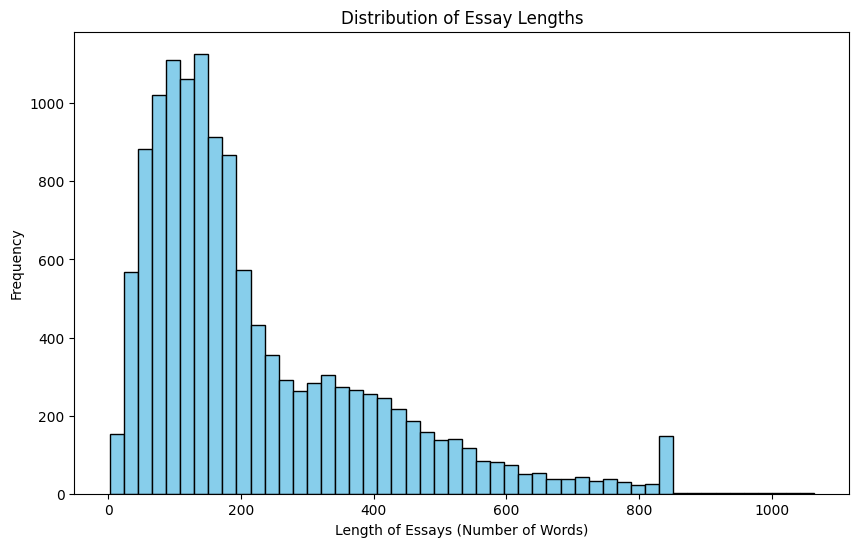

In [16]:
# Analyzing Essay Lengths for max_sequence_length

essay_lengths = data_set['essay'].apply(lambda x: len(x.split()))
mean_length = essay_lengths.mean()
median_length = essay_lengths.median()
percentile_95 = essay_lengths.quantile(0.95)

print(f"Mean Essay Length: {mean_length}")
print(f"Median Essay Length: {median_length}")
print(f"95th Percentile Length: {percentile_95}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(essay_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Essay Lengths')
plt.xlabel('Length of Essays (Number of Words)')
plt.ylabel('Frequency')
plt.show()


In [17]:
# 
all_words = [word for essay in data_set['essay'] for word in essay.split()]
vocab = set(all_words)
vocab_size = len(vocab)

print(f"Total Vocabulary Size: {vocab_size}")


Total Vocabulary Size: 78396


In [18]:
# Extracting the 'essay' column from the DataFrame using list comprehension
essays = [essay for essay in data_set['essay']]

# Define the maximum sequence length and vocabulary size based on your data analysis
max_sequence_length = 600
vocab_size = 20000

# Convert the essays to sequences
processed_data, tokenizer = essays_to_sequences(essays, remove_stopwords=True, max_sequence_length=max_sequence_length, vocab_size=vocab_size)


Found 37905 unique tokens.


In [19]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score

# Assuming you have already defined get_sequence_model() and essays_to_sequences()

cv = KFold(n_splits=5, shuffle=True)
results = []

count = 1
for traincv, testcv in cv.split(processed_data):
    print("\n--------Fold {}--------\n".format(count))
    
    X_train, y_train = processed_data[traincv], score_col.iloc[traincv]
    X_test, y_test = processed_data[testcv], score_col.iloc[testcv]
    
    # Define the sequence model
    sequence_model = get_sequence_model(sequence_length=max_sequence_length,
                                        word_vector_dim=300,  # Word vector dimensionality
                                        vocab_size=vocab_size)

    # Train the model
    sequence_model.fit(X_train, y_train, batch_size=64, epochs=2)

    # Predict on the test set
    y_pred = sequence_model.predict(X_test)

    # Round y_pred to the nearest integer
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1

    # Save the model at the last fold
    if count == 5:
        sequence_model.save('./model_weights/final_sequence_model.h5')



--------Fold 1--------



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 600, 300)          721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6814705 (26.00 MB)
Trainable params: 6814705 (26.00 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

c:\Users\Adefemi\Desktop\eassay_score\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



--------Fold 5--------

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 600, 300)          6000000   
                                                                 
 lstm_8 (LSTM)               (None, 600, 300)          721200    
                                                                 
 lstm_9 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6814705 (26.00 MB)
Trainable params: 6814705 (26.00 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

In [20]:
print("Rata-rata skor kappa: ", np.around(np.array(results).mean(),decimals=4))

Rata-rata skor kappa:  0.2682


In [24]:
import numpy as np
import math

essay_sample = """
    Dear @CAPS1 @CAPS2 I feel that computers do take away from peoples life and aren’t as important than the other factors of life. 
    First of all you know that the world is becoming obese because of lack of exercise. 
    Also, people are becoming more and more anti-social because of computers.
"""

# Assuming 'tokenizer' is the same tokenizer used during training
# and 'max_sequence_length' is defined as during data preprocessing

def preprocess_essay_to_sequence(essay, tokenizer, max_sequence_length):
    # Clean and tokenize the essay
    cleaned_essay = clean_essay(essay, remove_stopwords=True)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_essay])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=200)
    
    return padded_sequence

if len(essay_sample.strip()) > 20:
    # Preprocess the essay sample
    sequence = preprocess_essay_to_sequence(essay_sample, tokenizer, max_sequence_length)
    print(sequence)
    
    # Predict using the sequence model
    predict = sequence_model.predict(sequence)

    # Post-process the prediction
    predict = np.squeeze(predict)  # Remove single-dimensional entries
    predict = np.round(predict)    # Round to nearest integer

    # Handling edge cases
    if math.isnan(predict) or predict < 0:
        predict = 0
else:
    predict = 0

print(f"Predicted Score: {predict}")


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  219    2    2    1  113    6   33   85  866   24
   579    3  147 2149   24   26   67  869 1315    4  471  339   

In [ ]:
from keras.optimizers import RMSprop

# Adjust the learning rate
optimizer = RMSprop(learning_rate=0.001)  # Experiment with different values, e.g., 0.0001
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])


In [ ]:
# Adjust batch size in the fit method
batch_size = 32  # Experiment with different values, e.g., 16, 32, 64
lstm_model.fit(trainDataVecs, y_train, batch_size=batch_size, epochs=2)


In [ ]:
def get_simplified_model():
    model = Sequential()
    model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300]))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    return model

# Use the simplified model
lstm_model = get_simplified_model()


In [ ]:
from keras.initializers import GlorotUniform

def get_model_with_initialization():
    model = Sequential()
    # Example: Using GlorotUniform initializer
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], kernel_initializer=GlorotUniform()))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    return model


In [ ]:
from keras.regularizers import l2

def get_model_with_regularization():
    model = Sequential()
    # Example: Adding L2 regularization
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    return model


In [ ]:
from keras.optimizers import RMSprop

# Using gradient clipping in optimizer
optimizer = RMSprop(learning_rate=0.001, clipvalue=1.0)  # Clipvalue can be adjusted
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing the target values (scores)
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Use scaled values for training and predictions
lstm_model.fit(trainDataVecs, y_train_scaled, batch_size=64, epochs=2)


In [ ]:
# Increase the number of epochs
lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=10)  # Increase epochs, e.g., 10


In [ ]:
# Include validation data to monitor validation loss
lstm_model.fit(trainDataVecs, y_train, validation_data=(testDataVecs, y_test), batch_size=64, epochs=2)


# https://chat.openai.com/share/c1c547e0-9c1d-4a36-bdab-05b5dd594511
